In [1]:
import torch
import torch.nn as nn
import torchvision
from tqdm import tqdm

import pickle
from matplotlib import pyplot as plt

## 2. Targeted Attack

- 你已经实现了FGSM和PGD算法上的无目标攻击，接下来请实现两种算法上的有目标攻击

- 具体实验步骤如下：
  
  1. 将代码文件上传到服务器端根目录，将week5保存的lenet5.pt迁移到/model路径下
   
  2. 在服务器端根目录下新建目录data，并将week6新版样本数据（Week567_img_label.pkl）上传至/data目录下
   
  3. 依照提示，完成Python文件中`fgsm_target(imgs, epsilon, model, criterion, labels)`函数和`pgd_target(imgs, epsilon, iter, model, criterion, labels)`函数的*TODO*内容
   
  4. 执行代码完成攻击与效果验证

In [2]:
from Week567_General_Code_Question import LeNet5, fgsm_target, pgd_target, evaluate
from Week567_General_Code_Question import visualize_target_adv

### 目标模型加载

注意，请将week5保存的lenet5.pt迁移到/model路径下

In [3]:
model = LeNet5()
### 请将week5保存的lenet5.pt迁移到/model路径下
model.load_state_dict(torch.load('model/lenet5.pt'))
model.eval()

criterion = nn.CrossEntropyLoss()

C:\Users\w2213\AppData\Local\Temp\ipykernel_21204\4002751527.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model/lenet5.pt'))


### 读入待攻击的样本

注意，需导入week6的新版本Week567_img_label.pkl

In [4]:
with open('data/Week567_img_label.pkl', 'rb') as f:
    data = pickle.load(f)
    imgs, labels, target_labels = data['img'], data['label'], data['target_label']

### 2.1 FGSM

依照提示，完成Python文件中`fgsm_target(imgs, epsilon, model, criterion, labels)`函数的*TODO*内容：

  - labels参数为各样本的攻击目标类
       
  - 根据模型对样本预测结果计算与攻击目标类的loss，并回传、方便梯度获取 

  - 实现有目标FGSM对抗样本生成过程

  - **助教检查**时测试扰动大小$\epsilon=0.2$

  - **正确实现**要求match rate $ \ge 0.4$
    - *注: 若多次尝试后，仍未达到验收目标，推荐设置LeNet5中卷积层的kernel_size=5
  
  - 实现后评测对抗样本的攻击效果

下面是一些供你参考/可能用到的API函数：
- torch.Tensor.requires_grad [Link](https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad.html)
  - 设置tensor是否加入计算图，即是否需要反向累积梯度
- torch.Tensor.grad [Link](https://pytorch.org/docs/stable/generated/torch.Tensor.grad.html)
  - 在loss.backward()后，获取tensor上的梯度
- torch.Tensor.sign() [Link](https://pytorch.org/docs/stable/generated/torch.Tensor.sign.html)
  - 取一个tensor中每个元素的符号（正负1），返回的形状与输入相同
- torch.clamp(*input*, *min=None*, *max=None*, ***, *out=None*) [Link](https://pytorch.org/docs/stable/generated/torch.clamp.html)
  - input: 需要clip的tensor
  - min, max: 截断的阈值，使tensor中在[min, max]以外的值被截断至min或max
- torch.Tensor.detach() [Link](https://pytorch.org/docs/stable/generated/torch.Tensor.detach.html)
  - 获取一个脱离计算图的tensor，获得的tensor不再会被反向计算梯度

In [5]:
# perform fgsm attack and evaluate
epsilon = 0.2
fgsm_xs = fgsm_target(imgs, epsilon, model, criterion, target_labels)
pred_label = evaluate(fgsm_xs, target_labels, model)

match rate: 0.65


### 可视化对抗样本与结果

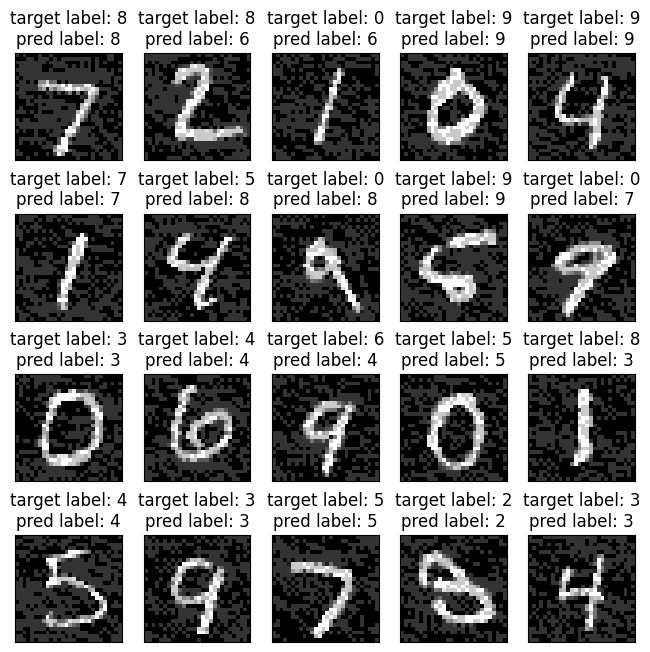

In [6]:
fgsm_imgs = fgsm_xs.reshape_as(imgs)
visualize_target_adv(fgsm_imgs, target_labels, pred_label)

### 2.2 PGD

依照提示，完成Python文件中`pgd_target(imgs, epsilon, iter, model, criterion, labels)`函数的*TODO*内容：

  - labels参数为各样本的攻击目标类
       
  - 根据模型对样本预测结果计算与攻击目标类的loss，并回传、方便梯度获取 

  - 实现有目标PGD对抗样本生成过程，在iter轮的优化过程中生成对抗扰动

  - **助教检查**时测试扰动大小$\epsilon=0.2$、攻击轮次$iter \in [5, 15, 30]$、单步步长$\alpha \in [0.03, 0.07, 0.15]$

  - **正确实现**要求**最佳攻击效果**的match rate $ \ge 0.9$
    - *注: 若多次尝试后，仍未达到验收目标，推荐设置LeNet5中卷积层的kernel_size=5
  
  - 实现后评测对抗样本的攻击效果

下面是一些供你参考/可能用到的API函数：
- torch.Tensor.requires_grad [Link](https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad.html)
  - 设置tensor是否加入计算图，即是否需要反向累积梯度
- torch.Tensor.grad [Link](https://pytorch.org/docs/stable/generated/torch.Tensor.grad.html)
  - 在loss.backward()后，获取tensor上的梯度
- torch.Tensor.sign() [Link](https://pytorch.org/docs/stable/generated/torch.Tensor.sign.html)
  - 取一个tensor中每个元素的符号（正负1），返回的形状与输入相同
- torch.clamp(*input*, *min=None*, *max=None*, ***, *out=None*) [Link](https://pytorch.org/docs/stable/generated/torch.clamp.html)
  - input: 需要clip的tensor
  - min, max: 截断的阈值，使tensor中在[min, max]以外的值被截断至min或max
- torch.Tensor.detach() [Link](https://pytorch.org/docs/stable/generated/torch.Tensor.detach.html)
  - 获取一个脱离计算图的tensor，获得的tensor不再会被反向计算梯度

In [7]:
# perform pgd attack and evaluate
epsilon = 0.2
iter = 15
alpha = 0.07
pgd_xs = pgd_target(imgs, epsilon, alpha, iter, model, criterion, target_labels)
pred_label = evaluate(pgd_xs, target_labels, model)

match rate: 1.0


### 可视化对抗样本与结果

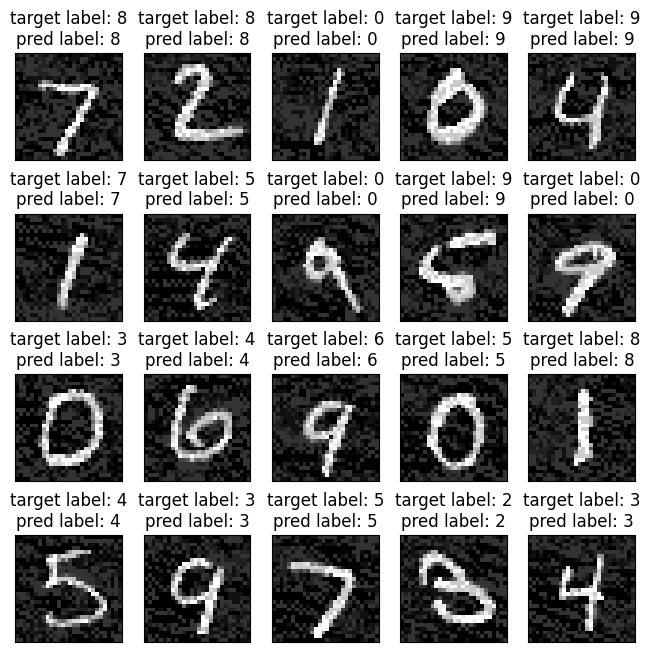

In [8]:
pgd_imgs = pgd_xs.reshape_as(imgs)
visualize_target_adv(pgd_imgs, target_labels, pred_label)

### 比较有目标攻击下的FGSM与PGD对抗样本

In [9]:
# Compute perturbation from original img
delta_fgsm = fgsm_imgs - imgs
delta_pgd = pgd_imgs - imgs

# Compute L2 distance
print(f'L2_FGSM: {delta_fgsm.pow(2).sum(dim=-1).sqrt().mean()}')
print(f'L2_PGD: {delta_pgd.pow(2).sum(dim=-1).sqrt().mean()}')

L2_FGSM: 0.7707504630088806
L2_PGD: 0.696507453918457
